In [157]:
import numpy as np
from skimage import draw
import matplotlib.pyplot as plt 
from skimage.morphology import skeletonize


cyl = np.zeros((128,128,128))
for i in range(cyl.shape[2]):
    off = np.sin(i / 128 * 2*np.pi) * 30
    rr, cc = draw.disk((64 + off/5, 64 + off/2), 10, shape=cyl.shape[0:2])
    cyl[rr, cc, i] = 1

skel = skeletonize(cyl.astype(np.uint8))


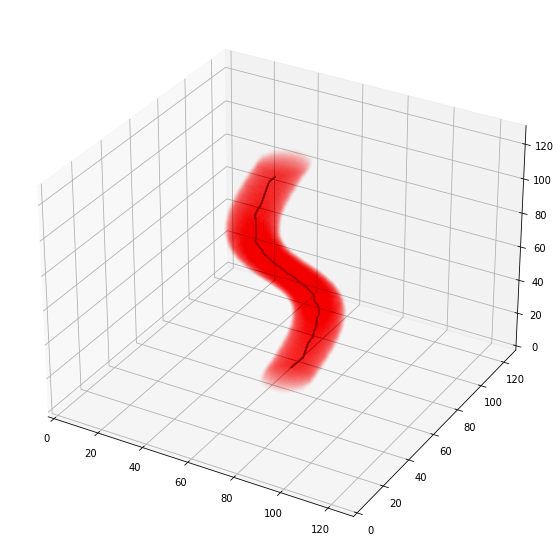

In [158]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# vessel
pos = np.where(cyl==1)
ax.scatter(pos[0], pos[1], pos[2], c='red', alpha=0.01)

# skeleton
one_pos = np.where(skel == 1)
idx = np.argsort(one_pos[2])
one = [None, None, None]
one[0] = one_pos[0][idx]
one[1] = one_pos[1][idx]
one[2] = one_pos[2][idx]
one = np.stack(one)
ax.plot(one[0][::3], one[1][::3], one[2][::3], c='black')

ax.set_xlim(0, cyl.shape[0])
ax.set_ylim(0, cyl.shape[1])
ax.set_zlim(0, cyl.shape[2])

plt.show()

In [133]:
def plane(grid_shape, point, normal):
    point = np.array(point)
    normal = np.array(normal)
    d = -point.dot(normal)
    xx, yy = np.meshgrid(range(grid_shape[0]), range(grid_shape[1]))

    z = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]

    z = z.astype(int)

    arr = np.array([[x, y, z[x, y]] for x in range(grid_shape[0]) for y in range(grid_shape[1])])

    plane_labelmap = np.zeros(cyl.shape)

    for r in arr:
        if r[2] in range(grid_shape[2]):
            plane_labelmap[r[0], r[1], r[2]] = 1
    plane_labelmap = plane_labelmap.astype(int)
    
    return plane_labelmap


In [161]:
# find vessel and skeleton labelmap
cyl = np.zeros((128,128,128))
for i in range(cyl.shape[2]):
    off = np.sin(i / 128 * 2*np.pi) * 30
    rr, cc = draw.disk((64 + off/5, 64 + off/2), 10, shape=cyl.shape[0:2])
    cyl[rr, cc, i] = 1

skel = skeletonize(cyl.astype(np.uint8))
# skeleton
one_pos = np.where(skel == 1)
idx = np.argsort(one_pos[2])
one = [None, None, None]
one[0] = one_pos[0][idx][::3]
one[1] = one_pos[1][idx][::3]
one[2] = one_pos[2][idx][::3]
one = np.stack(one)

distances = []

for i in range(one.shape[1]-1):
    # find plane
    normal = one[:, i+1] - one[:, i]
    p = plane(cyl.shape, one[:, i], normal)
    if i == 2:
        test = p
    intersection = p * cyl
    # enum directions
    
    dirs = enum_directions(intersection, *one[:, i])

    dist = []
    for d in dirs:
        p1 = walk_bound(intersection, one[:, i], d)
        p2 = walk_bound(intersection, one[:, i], -d)
        dist.append(np.linalg.norm(p1 - p2))
    distances.append((np.mean(dist), np.std(dist)))
    


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [160]:
distances

[(1.5731321849709863, 0.15891862259789102),
 (1.3949382989376324, 0.2326953849069299),
 (1.914213562373095, 0.7088392654851816),
 (nan, nan),
 (1.5731321849709863, 0.15891862259789102),
 (nan, nan),
 (nan, nan),
 (nan, nan),
 (nan, nan),
 (19.399494936611667, 0.39949493661166535),
 (nan, nan),
 (4.298788373301039, 5.789682074308726),
 (18.692388155425117, 0.30761184457488255),
 (nan, nan),
 (nan, nan),
 (1.9790009531712873, 0.8093106936002434),
 (1.5731321849709863, 0.15891862259789102),
 (nan, nan),
 (1.9790009531712875, 0.8093106936002435),
 (1.2761423749153966, 0.19526214587563503),
 (1.9790009531712875, 0.8093106936002434),
 (5.37831517751085, 4.906498328885523),
 (3.6656464399979107, 4.2078371308533065),
 (1.626105059170283, 0.1498299142610593),
 (1.5731321849709863, 0.15891862259789102),
 (nan, nan),
 (nan, nan),
 (nan, nan),
 (nan, nan),
 (18.692388155425117, 0.30761184457488255),
 (18.79594154601839, 0.6801333682887173),
 (18.54594154601839, 0.7403054583541524),
 (nan, nan),
 (

In [45]:
def nearest_nonzero_idx(a,x,y,z):
    tmp = a[x,y,z]
    a[x,y,z] = 0
    i, j, k = np.nonzero(a)
    a[x,y,z] = tmp
    min_idx = ((i - x)**2 + (j - y)**2 + (k-z)**2).argmin()
    return [i[min_idx], j[min_idx], k[min_idx]]

nearest = nearest_nonzero_idx(inter, *sp)
d = np.array(nearest) - np.array(sp)



[79, 78, 14]


1.0

In [116]:
def enum_directions(a, x, y, z):
    cube = a[x-1:x+2, y-1:y+2, z-1:z+2]
    cube[1,1,1] = 0
    dirs = (np.stack(np.where(cube == 1))-1).T
    res = []
    for d in dirs:
        if (-d).tolist() not in res:
            res.append(d.tolist())
    return np.array(res)

dirs = enum_directions(inter, *sp)


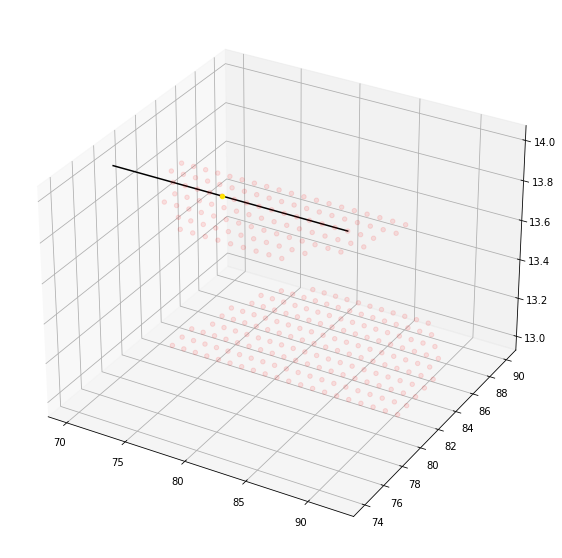

In [117]:


line = [np.array(sp) + i*dirs[1] for i in range(-10, 10)]


inter = p * cyl

pos = np.where(inter == 1)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pos[0], pos[1], pos[2], c='red', alpha=0.1)
ax.scatter(79 ,78 ,14, c='yellow')

pos = np.array(line).T

ax.plot(pos[0], pos[1], pos[2], c='black', alpha=1)


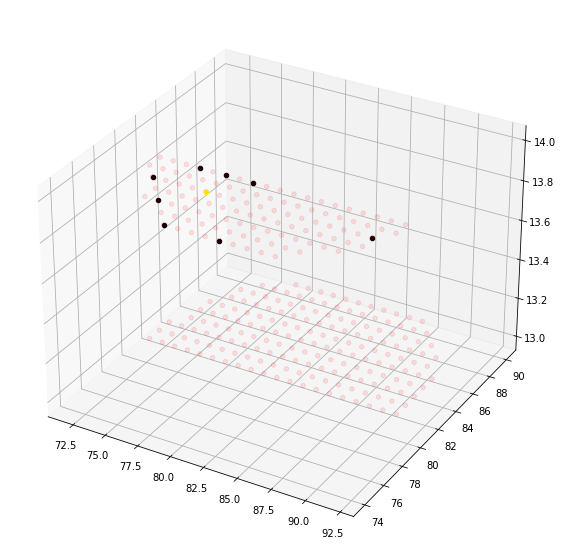

In [118]:
def walk_bound(a, point, direction):
    i = 1
    p = np.array(point)
    d = np.array(direction)
    while True:
        try:
            idx =  p + i * d
            t_val = a[idx[0],idx[1],idx[2]]
            if t_val != 1:
                return idx -  d
            i = i + 1
        except Exception as e:
            return idx - d



fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

pos = np.where(inter == 1)
ax.scatter(pos[0], pos[1], pos[2], c='red', alpha=0.1)
ax.scatter(*sp, c='yellow')
for d in dirs:
    p1 = walk_bound(inter, sp, d)
    p2 = walk_bound(inter, sp, -d)
    ax.scatter(*p1, c='black', alpha=1)
    ax.scatter(*p2, c='black', alpha=1)

        

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# vessel
pos = np.where(cyl==1)
ax.scatter(pos[0], pos[1], pos[2], c='red', alpha=0.01)

# skeleton
one_pos = np.where(skel == 1)
idx = np.argsort(one_pos[2])
one = [None, None, None]
one[0] = one_pos[0][idx]
one[1] = one_pos[1][idx]
one[2] = one_pos[2][idx]
one = np.stack(one)
ax.plot(one[0][::3], one[1][::3], one[2][::3], c='black')

ax.set_xlim(0, cyl.shape[0])
ax.set_ylim(0, cyl.shape[1])
ax.set_zlim(0, cyl.shape[2])

plt.show()